This notebook provides the plotting functions for Figure 3 a-f. It also includes the warping function used to transform the chirp response in Figure 2e. The warping is achieved using isotonic regression.

In [5]:
%matplotlib inline

import GPy
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import beta
from sklearn.isotonic import IsotonicRegression

from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *

sns.set_style('white')

# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True}) # ?

directories = json.load(open('directories.json'))

In [6]:
data_linear = load_hdf5(directories['data'] + 'SMP_M1_RR2_BC2_ChirpI.h5')

data_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_BC2_ChirpI.csv', index_col = 0)
data_df = data_df.groupby(['roi', 'frame']).mean().reset_index()
trial_duration = data_df['x_t'].max() / 2

In [7]:
chirp_stimulus = h5py.File(directories['misc'] + 'chirp.h5', 'r')['chirp'][:]

chirp_stimulus -= chirp_stimulus.mean()
chirp_stimulus /= chirp_stimulus.std()

chirp_tpnts = np.linspace(0, trial_duration, chirp_stimulus.shape[0])

In [8]:
def rbf_func(tpnts, l, sigma, v = 2):
    
    euc_dist_sqr = np.abs(- tpnts[:, None]) ** v
    sqr_dist_scale = euc_dist_sqr / (2 * l ** v)
    rbf_out = sigma * np.exp(-sqr_dist_scale)
    
    return rbf_out[:, 0]

In [9]:
n_anchors = 512
slice_width = 0.25
anchors = np.linspace(0, trial_duration, n_anchors)

In [10]:
slices = []

slice_length = 64
fit_stack = np.zeros([slice_length, n_anchors])
par_stack = np.zeros([2, n_anchors]) 
new_tpnts = np.linspace(-slice_width, slice_width, slice_length)

p0 = [0.1, 100]

slice_list = []
tpnts_list = []

for itx, anchor_point in enumerate(anchors):
    start = anchor_point - slice_width
    stop = anchor_point + slice_width
    anchor_mask = (chirp_tpnts > start) & (chirp_tpnts < stop)
    
    trace_slice = chirp_stimulus[anchor_mask]
    tpnts_slice = chirp_tpnts[anchor_mask]
    
    y_distance = np.correlate(trace_slice, trace_slice, mode = 'same')
    x_distance = np.linspace(-slice_width, slice_width, y_distance.shape[0])
    
    slice_list.append(y_distance)
    
    popt, pcov = curve_fit(rbf_func, x_distance, y_distance, p0 = p0)
    par_stack[:, itx] = popt 
    fit_stack[:, itx] = rbf_func(new_tpnts, popt[0], popt[1])
    
par_stack[0, :] = np.abs(par_stack[0, :])

In [11]:
par_cdf = np.cumsum(np.power(par_stack[0, :], -1))
par_cdf -= par_cdf.min()
par_cdf /= par_cdf.max()
par_cdf *= 32

par_length = par_stack.shape[1]
par_tpnts = np.linspace(0, trial_duration, par_stack.shape[1])
new_cdf = np.linspace(0, trial_duration, par_tpnts.shape[0])
cdf_transformed = IsotonicRegression().fit_transform(par_cdf, par_tpnts)

iso_reg = IsotonicRegression()
iso_reg.fit(par_tpnts, par_cdf)
x_ = iso_reg.transform(chirp_tpnts)

In [31]:
roi

9.0

In [50]:
roi = np.unique(data_df['roi'])[0]

data_df = data_df.sort_values(by = 'x_t')

y = data_df[data_df['roi'] == roi]['y']
x_t = data_df[data_df['roi'] == roi]['x_t']

global_mask = x_t < trial_duration
local_mask = x_t > trial_duration

x_t_local = x_t[local_mask]
x_t_local -= trial_duration
y_local = y[local_mask]

x_t_global = x_t[global_mask]
y_global = y[global_mask]

x_new_local = iso_reg.transform(x_t_local)
x_new_global = iso_reg.transform(x_t_global)

x_predict = np.linspace(0, trial_duration, 33 * 50)
x_predict_warp = iso_reg.transform(x_predict)

Warp Files

Plots

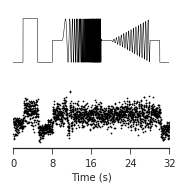

In [51]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

offset = 5

stimulus_tpnts = np.linspace(0, 32, chirp_stimulus.shape[0])
ax.plot(stimulus_tpnts, chirp_stimulus, c = 'k', linewidth = 0.5)

ax.scatter(x_t_local, y_local - offset, s = 0.5, c = 'k')

sns.despine(left = True, ax = ax)
ax.set_yticklabels([]);

ax.set_xlim(0, 32);

ax.set_xlabel('Time (s)', fontsize=10);
plt.xticks([0, 8, 16, 24, 32])
ax.get_yaxis().set_visible(False)
plt.tick_params(axis='both', which='major', labelsize = 'medium')

fig.set_size_inches(2.8, 2.5)

plt.savefig(directories['figs'] + 'warping/' + 'chirp_stimulus.svg', dpi = 300)

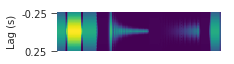

In [34]:
sns.set_style('ticks')

hmap_p = {
#     'square': True, 
    'cmap': 'viridis',
    'xticklabels': False,
    'yticklabels': False,
    'cbar': False,
}

fig, ax = plt.subplots(1)
sns.heatmap(fit_stack, ax = ax, **hmap_p)
plt.yticks([1, 64])
ax.set_yticklabels([-0.25, 0.25]);
ax.set_ylabel('Lag (s)', fontsize=10, clip_on = False);

plt.tick_params(axis='both', which='major', labelsize = 'medium')

fig.set_size_inches(3.35, 1)

plt.tight_layout()

plt.savefig(directories['figs'] + 'warping/' + 'heatmap_fitted_acf.png', dpi = 600)

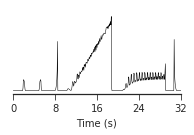

In [35]:
par_cdf_rescale = np.power(par_stack[0, :], -1).max() / 32
par_cdf_offset = np.power(par_stack[0, :], -1).max()

fig, ax = plt.subplots(1)

ax.plot(par_tpnts, np.power(par_stack[0, :], -1), 
           c = 'k', alpha = 1, label = '1 / Lengthscale', linewidth = 0.5)

# ax.plot(par_tpnts, par_cdf * par_cdf_rescale + par_cdf_offset, c = 'b', linewidth = 0.5, label = 'Cumulative')

ax.set_yticklabels([]);
ax.set_xlim(0, 32)
ax.set_xlabel('Time (s)', fontsize=10);
plt.xticks([0, 8, 16, 24, 32])
ax.get_yaxis().set_visible(False)
plt.tick_params(axis='both', which='major', labelsize = 'medium')
sns.despine(left = True, ax = ax)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'acf_parameters.svg', dpi = 300)

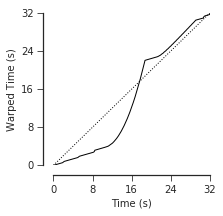

In [36]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(par_tpnts, par_cdf, color = 'k', linewidth = 1)
ax.plot(par_tpnts, par_tpnts, color = 'k', linewidth = 1, linestyle = ':')

plt.xticks([0, 8, 16, 24, 32])
plt.yticks([0, 8, 16, 24, 32])
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
ax.set_xlabel('Time (s)', fontsize=10)
ax.set_ylabel('Warped Time (s)', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize='medium')
sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2.8, 2.8)

plt.savefig(directories['figs'] + 'warping/' + 'time_vs_warpedtime.svg', dpi = 300)

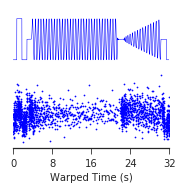

In [37]:
fig, ax = plt.subplots(1)

offset = 5

ax.plot(x_, chirp_stimulus, color = 'b', linewidth = 0.5)

ax.scatter(x_new_local, y_local - offset, s = 0.5, c = 'b')

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Warped Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)

sns.despine(left = True, ax = ax)
fig.set_size_inches(2.8, 2.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_stimulus.svg', dpi = 300)

In [52]:
m1 = GPy.models.SparseGPRegression(
    x_t_global[:, None],
    y_global[:, None],
    kernel = GPy.kern.RBF(1),
    num_inducing = 300
)

m1.optimize_restarts(4, max_iters = 25, messages = False)
# m1.plot()

Optimization restart 1/4, f = 916.7926476586917
Optimization restart 2/4, f = 1698.1606824686928
Optimization restart 3/4, f = 1634.2468256745944
Optimization restart 4/4, f = 1632.7499237250504


In [53]:
m2 = GPy.models.SparseGPRegression(
    x_new_global[:, None],
    y_global[:, None],
    kernel = GPy.kern.RBF(1),
    num_inducing = 300
)

m2.optimize_restarts(4, max_iters = 25, messages = False)
# m2.plot()

Optimization restart 1/4, f = 976.0836831998777
Optimization restart 2/4, f = 1576.3835086790298
Optimization restart 3/4, f = 1576.3575723623926
Optimization restart 4/4, f = 1576.4868539008655


In [54]:
m3 = GPy.models.SparseGPRegression(
    x_new_local[:, None],
    y_local[:, None],
    kernel = GPy.kern.RBF(1),
    num_inducing = 300
)

m3.optimize_restarts(4, max_iters = 25, messages = False)
# m3.plot()

Optimization restart 1/4, f = 1070.1178314717733
Optimization restart 2/4, f = 1598.9555232972396
Optimization restart 3/4, f = 1599.1862745256308
Optimization restart 4/4, f = 1599.3153454736466


In [55]:
m1_mu, m1_sig = m1.predict(x_predict[:, None], include_likelihood = False)
m1_mu, m1_sig_outer = m1.predict(x_predict[:, None], include_likelihood = True)

m2_mu, m2_sig = m2.predict(x_predict_warp[:, None], include_likelihood = False)
m2_mu, m2_sig_outer = m2.predict(x_predict_warp[:, None], include_likelihood = True)

m3_mu, m3_sig = m3.predict(x_predict_warp[:, None], include_likelihood = False)
m3_mu, m3_sig_outer = m3.predict(x_predict_warp[:, None], include_likelihood = True)

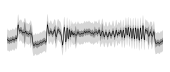

In [56]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_predict, m1_mu, color = 'k', linewidth = 0.5)
upper, lower = compute_bounds(m1_mu, m1_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)
upper, lower = compute_bounds(m1_mu, m1_sig_outer, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.set_xlim(0, 32)
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_yticklabels([]);
ax.set_xticklabels([]);
ax.set_ylim(-3, 3)
ax.set_aspect(2)
sns.despine(left = True, bottom = True, ax = ax)

fig.set_size_inches(2.8, 1.5)

# plt.savefig(directories['figs'] + 'warping/' + 'raw_gp.svg', dpi = 300)

In [57]:
n_samples = 5
mu_post = m1.posterior_samples_f(x_predict[:, None], size = n_samples)

 /usr/local/lib/python3.5/dist-packages/GPy/core/gp.py:590: RuntimeWarning:covariance is not positive-semidefinite.


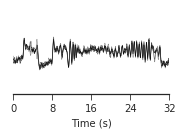

In [58]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

sample_colors = sns.color_palette('hls', n_samples)

offset = 0

for itx in range(n_samples):
    ax.plot(x_predict, mu_post[:, itx] + itx * offset, color = 'k', alpha = 0.5, linewidth = 0.5)
    
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
ax.set_ylim(-3, 3)
sns.despine(ax = ax, left = True)

fig.set_size_inches(2.8, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'raw_gp_samples.svg', dpi = 300)

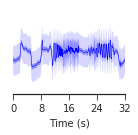

In [122]:
fig, ax = plt.subplots(1)

ax.plot(x_predict, m2_mu, color = 'b', linewidth = 0.5)
upper, lower = compute_bounds(m2_mu, m2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'b', alpha = 0.33)
upper, lower = compute_bounds(m2_mu, m2_sig_outer, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'b', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_gp_global.svg', dpi = 300)

In [65]:
n_samples = 5
mu_post = m2.posterior_samples_f(x_predict_warp[:, None], size = n_samples)

 /usr/local/lib/python3.5/dist-packages/GPy/core/gp.py:590: RuntimeWarning:covariance is not positive-semidefinite.


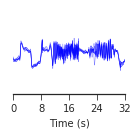

In [121]:
fig, ax = plt.subplots(1)

sample_colors = sns.color_palette('hls', n_samples)

offset = 0

for itx in range(n_samples):
    ax.plot(x_predict, mu_post[:, itx] + itx * offset, color = 'b', alpha = 0.5, linewidth = 0.5)
    
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_gp_samples.svg', dpi = 300)

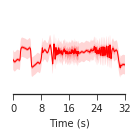

In [119]:
fig, ax = plt.subplots(1)

ax.plot(x_predict, m3_mu, color = 'r', linewidth = 1)
upper, lower = compute_bounds(m3_mu, m3_sig, n_sigma = 2)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'r', alpha = 0.33)
upper, lower = compute_bounds(m3_mu, m3_sig_outer, n_sigma = 2)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'r', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_gp_local.svg', dpi = 300)

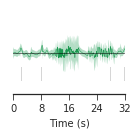

In [120]:
fig, ax = plt.subplots(1)

ax.plot(x_predict, m2_mu - m3_mu, color = '#1a9850', linewidth = 0.5)
ax.plot(x_predict, np.zeros(x_predict.shape), color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(m2_mu - m3_mu, m2_sig + m3_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

diff_mask = (upper < 0) | (lower > 0)

# upper, lower = compute_bounds(m2_mu - m3_mu, m2_sig_outer + m3_sig_outer, n_sigma = 3)
# ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.16)

y_min = - 1

ax.fill_between(
    x_predict, 
    np.ones(x_predict.shape) * 2 * y_min, 
    np.ones(x_predict.shape) * y_min, 
    where = diff_mask[:, 0], 
    facecolor = 'k', 
    alpha = 0.16
)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'diff_gp.svg', dpi = 300)

In [87]:
n_sigma = np.linspace(0, 10, 200)

n_blob_inner = np.zeros(n_sigma.shape[0])
n_blob_outer = np.zeros(n_sigma.shape[0])

In [159]:
from scipy.ndimage import label

for itx, sigma in enumerate(n_sigma):
    # Compute inner EC
    upper, lower = compute_bounds(m2_mu - m3_mu, m2_sig + m3_sig, n_sigma = sigma)
    ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_inner[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

    # Compute outer EC
    upper, lower = compute_bounds(m2_mu - m3_mu, m2_sig_outer + m3_sig_outer, n_sigma = sigma)
    ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    n_blob_outer[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

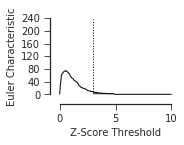

In [161]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_inner, color = 'k', linewidth = 1, clip_on = False)
ax.plot(np.ones(240) * 3, np.arange(240), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_inner[sigma_mask],
    facecolor = 'k', 
    alpha = 0.66,
    clip_on = False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 240)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 5))
plt.yticks(np.arange(0, 280, 40))

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 1.4)

plt.savefig(directories['figs'] + 'warping/' + 'zscore_vs_ec.svg', dpi = 300)

Classical Comparison

In [102]:
local_traces = data_linear['Snippets0'][:16515, :, 0]
global_traces = data_linear['Snippets0'][16516:, :, 0]

local_mean = local_traces.mean(axis = 1)
global_mean = global_traces.mean(axis = 1)

local_std = local_traces.std(axis = 1)
global_std = global_traces.std(axis = 1)

trace_times = data_linear['SnippetsTimes0'][:16515, 0, 0]
trace_times -= trace_times.min()

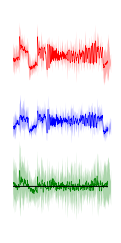

In [157]:
fig, ax = plt.subplots(1)

offset = 18

ax.plot(trace_times, local_mean + 2 * offset, color = 'r', linewidth = 0.5)
ax.fill_between(trace_times, local_mean - 3 * local_std + 2 * offset,  local_mean + 3 * local_std + 2 * offset,
                facecolor = 'r', alpha = 0.33, clip_on = False)

ax.plot(trace_times, global_mean + offset, color = 'b', linewidth = 0.5)
ax.fill_between(trace_times, global_mean - 3 * global_std + offset,  global_mean + 3 * global_std + offset, 
                facecolor = 'b', alpha = 0.33, clip_on = False)

ax.plot(trace_times, local_mean - global_mean , color = 'g', linewidth = 0.5)
ax.plot(x_predict, np.zeros(x_predict.shape), color = 'k', linewidth = 1)

ax.fill_between(trace_times, 
                local_mean - global_mean - 3 * (local_std + global_std),  
                local_mean - global_mean + 3 * (local_std + global_std), 
                facecolor = 'g', alpha = 0.33, clip_on = False)

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

ax.set_xlim(0, 32)

# plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, bottom = True, ax = ax, offset = 10)

fig.set_size_inches(1.7, 4)

plt.savefig(directories['figs'] + 'warping/' + 'classical_diff.pdf', dpi = 300)

In [162]:
n_blob_inner = np.zeros(n_sigma.shape[0])

for itx, sigma in enumerate(n_sigma):
    # Compute EC
    upper, lower = compute_bounds(local_mean - global_mean, local_std + global_std, n_sigma = sigma)
    ax.fill_between(trace_times, upper, lower, facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_inner[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

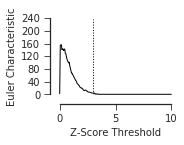

In [163]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_inner, color = 'k', label = 'Latent', linewidth = 1, clip_on = False)
ax.plot(np.ones(240) * 3, np.arange(240), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_inner[sigma_mask],
    facecolor = 'k', 
    alpha = 0.66,
    clip_on = False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 240)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 5))
plt.yticks(np.arange(0, 280, 40))

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 1.4)

plt.savefig(directories['figs'] + 'warping/' + 'classical_EC.svg', dpi = 300)